# Chatterjee's $\xi$

## 概要

Chatterjee (2021) によって提案された **ξ（xi）相関係数** は、

- **あらゆる形の依存関係（線形・非線形）に対して感度が高い**
- **ノンパラメトリック**で順位に基づく
- **$X$ の分布に依存しない（一様性の仮定が不要）**
- 計算量が **$O(n \log n)$** と高速（先行研究のMICは遅い）

という特徴を持つ新しい相関係数である。

目的は、「$Y$ が $X$ にどれだけ依存しているか」を測ることであり、特に回帰関係一般に対する依存度測定として利用できる。

## アルゴリズム

$(X, Y)$を確率変数のペアとし、$n\geq 2$のiidな標本があるとする。

**Step 1. データの並び替え**

データ $(X_{(1)}, Y_{(1)}), \ldots,(X_{(n)}, Y_{(n)})$ を $X$ で昇順 $X_{(1)} \leq \cdots \leq X_{(n)}$ に並べ替える。

同値がいれば一様にランダムに選ぶ。

**Step 2. 相関係数$\xi_n$を計算する**

$Y_{(j)} \leq Y_{(i)}$の$j$、すなわち$Y_{(i)}$の順位を$r_i$とする。  
$Y_{(j)} \geq Y_{(i)}$の$j$、すなわち$Y_{(i)}$の逆順位を$l_i$とする。


同順位がいない場合：

$$
\xi_n(X, Y):=1-\frac{3 \sum_{i=1}^{n-1}\left|r_{i+1}-r_i\right|}{n^2-1}
$$

同順位がいる場合：


$$
\xi_n(X, Y):=1-\frac{n \sum_{i=1}^{n-1}\left|r_{i+1}-r_i\right|}{2 \sum_{i=1}^n l_i\left(n-l_i\right)}
$$

## 実装

scipyに実装されている

[chatterjeexi — SciPy v1.16.2 Manual](https://docs.scipy.org/doc/scipy-1.16.2/reference/generated/scipy.stats.chatterjeexi.html)


```python
from scipy.stats import chatterjee
xi = chatterjee(x, y)
```

In [27]:
import numpy as np
from scipy.stats import rankdata

def chatterjee_xi(x, y):
    """
    Compute Chatterjee (2021) xi correlation.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    n = x.size

    # --- Step 1: Sort pairs by X (X(1),...,X(n)) ---
    idx = np.argsort(x)
    y_sorted = y[idx]

    # --- Step 2: r_i, l_i (rank and reverse rank of Y(i)) ---
    r = rankdata(y_sorted, method="max")      # r_i = rank(Y(i))
    l = rankdata(-y_sorted, method="max")     # l_i = reverse rank = rank(-Y(i))

    # --- Step 3: num = Σ|r_{i+1} - r_i| ---
    num = np.sum(np.abs(np.diff(r)))

    # --- Step 4: xi_n ---
    has_tie = all(x != np.unique(x)) or all(y != np.unique(y))
    if has_tie:
        den = np.sum((n - l) * l)
        xi = 1 - n * num / (2 * den)
    else:
        xi = 1 - 3 * num / (n**2 - 1)
    return xi


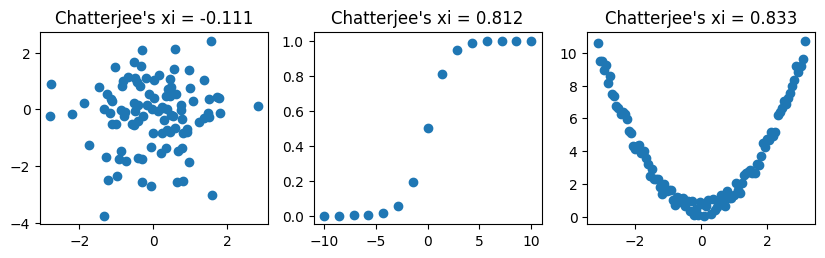

In [25]:
import numpy as np
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=[10, 2.5], ncols=3)

true_r = 0
mu = np.array([0.0, 0.0])
Sigma = np.array([[1.0, true_r], [true_r, 1.0]])
samples = np.random.multivariate_normal(mu, Sigma, size=100)
x = samples[:, 0]
y = samples[:, 1]
axes[0].scatter(x, y)
axes[0].set_title(f"Chatterjee's xi = {chatterjee_xi(x, y):.3f}")

x = np.linspace(-10, 10, 15)
y = 1 / (1 + np.exp(-x))
axes[1].scatter(x, y)
axes[1].set_title(f"Chatterjee's xi = {chatterjee_xi(x, y):.3f}")

x = np.linspace(-3.14,3.14, 100)
y = x**2 + np.random.random(len(x))
axes[2].scatter(x, y)
axes[2].set_title(f"Chatterjee's xi = {chatterjee_xi(x, y):.3f}")

%matplotlib inline

## 参考

- [著者のスライド](https://souravchatterjee.su.domains/beam-correlation-trans.pdf)
- Sourav Chatterjee (2021) A New Coefficient of Correlation, Journal of theAmerican Statistical Association, 116:536, 2009-2022 https://doi.org/10.1080/01621459.2020.1758115